In [1]:
from typing import Any

import lightning.pytorch as pl
import torch
from lightning.pytorch.callbacks import ModelCheckpoint
import mlflow
from torch.utils.data import DataLoader, Dataset

from src.ml.data.splitting import create_data_splits
from src.ml.modeling import (
    model_factory,
    optimizer_factory,
)
from src.ml.utils.set_seed import set_seed

from datetime import datetime
from loguru import logger
from pathlib import Path
from shutil import copy, copytree, rmtree

import yaml

from src.ml.train_neural_network import train_neural_network
from src.ml.data import data_sets_factory
from src.ml.preprocessing import preprocessing_factory
from src.ml.utils.set_seed import set_seed

In [2]:
CONFIG_FILE = Path("src/ml/config.yaml")

with open(CONFIG_FILE, "r") as f:
    config = yaml.safe_load(f)

In [3]:
from src.ml.modeling.weight_sharing_tree_flow import WeightSharingTreeFlow

model = WeightSharingTreeFlow.load_from_checkpoint("ml_data/models/debug_2025_01_12_18_23_45/yule-20_197/epoch=09-val_loss=-45.70.ckpt")
model = model.eval()

In [4]:
from src.ml.data.tree_dataset import TreeDataset

map_tree_file = Path("data/map_data/yule-20_197_48460_mrca.trees")
data_set = TreeDataset(map_tree_file)

for preprocessing_step in config["preprocessing"]:
    transform = preprocessing_factory(**preprocessing_step)
    data_set = transform(data_set)

data_loader = DataLoader(data_set, batch_size=1)

mrca_batch = next(iter(data_loader))

In [5]:
# load data

_, data_sets = next(iter(data_sets_factory(**config["data_set"])))

# preprocess data

for preprocessing_step in config["preprocessing"]:
    logger.info("Perform {} preprocessing.", preprocessing_step["name"])

    transform = preprocessing_factory(**preprocessing_step)
    data_sets = transform(data_sets)

dataset = data_sets

2025-01-13 09:19:46.587 | INFO     | __main__:<module>:8 - Perform add_taxa_names preprocessing.
2025-01-13 09:19:48.495 | INFO     | __main__:<module>:8 - Perform add_relative_clade_information preprocessing.
2025-01-13 09:19:51.400 | INFO     | __main__:<module>:8 - Perform remove_tree preprocessing.


In [8]:
# find corresponding clade vector

branch_lengths_per_clade = [
    dict(zip(sample["clades"], sample["branch_lengths"])) for sample in dataset
]
branch_lengths_per_clade

[{3: tensor(0.9904),
  192: tensor(0.1090),
  448: tensor(0.9257),
  544: tensor(0.4557),
  992: tensor(0.3419),
  995: tensor(0.1217),
  4104: tensor(0.9601),
  5099: tensor(0.0597),
  8196: tensor(0.5956),
  18432: tensor(0.0954),
  294912: tensor(0.1709),
  360448: tensor(0.6649),
  378880: tensor(0.6465),
  379904: tensor(0.1465),
  524304: tensor(0.4875),
  655376: tensor(0.6558),
  663572: tensor(0.1480),
  1043476: tensor(0.1840),
  1048575: tensor(1.0000e-06)},
 {3: tensor(0.9770),
  320: tensor(0.0767),
  448: tensor(0.9446),
  544: tensor(0.5988),
  992: tensor(0.1477),
  995: tensor(0.1035),
  4104: tensor(0.9661),
  5099: tensor(0.0302),
  8196: tensor(0.6244),
  294912: tensor(0.0703),
  360448: tensor(0.6808),
  362496: tensor(0.1484),
  378880: tensor(0.5521),
  379904: tensor(0.2463),
  524304: tensor(0.5168),
  655376: tensor(0.6548),
  663572: tensor(0.2189),
  1043476: tensor(0.0790),
  1048575: tensor(1.0000e-06)},
 {3: tensor(0.9806),
  320: tensor(0.0804),
  448: 

In [9]:
import numpy as np

mrca_clades = list(int(x) for x in mrca_batch["clades"])

samples_with_mrca_topology = np.array([
    sample["branch_lengths"]
    for sample in dataset
    if list(int(y) for y in sample["clades"]) == mrca_clades
])
np.random.shuffle(samples_with_mrca_topology)

In [19]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import numpy as np

hull = ConvexHull(samples_with_mrca_topology[:30, :-1])

In [38]:
samples = [model.sample(mrca_batch) for _ in range(500)]
sampled_branch_lengths = torch.cat([sample["branch_lengths"] for sample in samples]) 

In [61]:
approximate_hull = []

for dim in range(sampled_branch_lengths.shape[1]):
    sorted_by_dim = torch.argsort(sampled_branch_lengths[:, dim])
    approximate_hull.append(sampled_branch_lengths[sorted_by_dim[0]])
    approximate_hull.append(sampled_branch_lengths[sorted_by_dim[-1]])

approximate_hull = torch.stack(approximate_hull)

In [107]:
from torch import nn

class Module(nn.Module):
    def __init__(self, model, approximate_hull, clades, tree_height, **kwargs):
        super().__init__()
        model.freeze()
        
        self.convex_factors = torch.nn.Parameter(torch.rand(len(approximate_hull)), requires_grad=True)
        
        self.approximate_hull = approximate_hull.T.detach()

        self.wrapped_model = model
        self.clades = clades
        self.tree_height = tree_height

    def loss(self):
        normalized_convex_factors = torch.softmax(self.convex_factors, 0)
        branch_lenghts = self.approximate_hull @ normalized_convex_factors

        batch = {
            "branch_lengths": branch_lenghts.unsqueeze(0),
            "clades": self.clades,
            "tree_height": self.tree_height,
        }

        return -self.wrapped_model.get_log_likelihood(batch)

wrapped_model = Module(model, approximate_hull, **mrca_batch)
optim = torch.optim.SGD(wrapped_model.parameters(), lr=1e-1)

losses = []

num_steps = 100
for _ in range(num_steps):
    loss = wrapped_model.loss()
    loss.backward()
    optim.step()
    optim.zero_grad()
    losses.append(float(loss))

<Axes: >

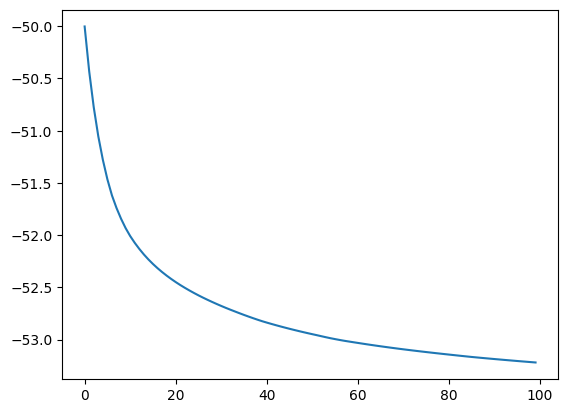

In [108]:
import seaborn as sns

sns.lineplot(losses)

In [109]:
normalized_convex_factors = torch.softmax(wrapped_model.convex_factors, 0)
map_branch_lenghts = wrapped_model.approximate_hull @ normalized_convex_factors

In [112]:
(map_branch_lenghts * 100).round()

tensor([98., 39., 95., 47., 22., 12., 95., 10., 68., 17., 60.,  7., 59., 19.,
        44., 68., 22., 15.,  0.], grad_fn=<RoundBackward0>)

In [116]:
(mrca_batch["branch_lengths"][0] * 100).round()

tensor([98., 38., 94., 44., 25., 14., 94.,  6., 67., 12., 61.,  3., 59., 18.,
        45., 68., 21., 17.,  0.])

In [138]:
mrca_batch["branch_lengths"] = map.detach()
model.get_log_likelihood(mrca_batch)

tensor([19.0946])

In [135]:
map

tensor([[0.1830, 0.0770, 0.0570, 0.0520, 0.1510, 0.2360, 0.1680, 0.1940, 0.0000]],
       grad_fn=<DivBackward0>)